In [1]:
import numpy as np
import pandas as pd
import re
from googletrans import Translator
from textblob import TextBlob
import string

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import nltk 
from nltk import tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

import seaborn as sns
sns.set(style="white", palette="tab10")
sns.color_palette("Blues")

import warnings
warnings.simplefilter(action="ignore")

import matplotlib.pyplot as plt
% matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
data = pd.read_csv("indeed_scraping ouput.csv") #shape = (5000, 5)
data = data.replace("None", np.nan)
data.drop_duplicates(inplace=True) #shape = (858, 6)
data.reset_index(inplace=True)
del data["index"]
data.sample(7)

,Title,Location,Company,Salary,Description
489,Report Developer,Indonesia,Rhino Technology,NaN,Kindly submit your CV details to info@rhino.co...
171,IT Visual Basic,Jakarta,Valdo Inc.,NaN,Pria/ Wanita\nLulusan D3/ S1\nFresh graduate\n...
533,MT - Branch Telesales Head,Tangerang,PT BFI Finance Indonesia Tbk,NaN,KUALIFIKASI :\nUsia maksimal 27 tahun\n\nPendi...
110,Merchandising (MD),Indonesia,Kridha Multiniaga Prima,NaN,"Anda people oriented, suka tantangan, dan ingi..."
626,Business Development Executive,Jakarta,exabytes,NaN,Responsibilities:\nAbility to generate own sal...
348,Adm Supply Chain,Jakarta,PT Mersifarma Tirmaku Mercusana,NaN,Persyaratan\n\nPria/ Wanita\n\nUsia maks 28 ta...
600,Staff Marketing,Cilacap,PT BFI Finance Indonesia Tbk,NaN,PT. BFI Finance Indonesia Tbk. membagi posisi ...


# Title Columns

In [4]:
satu = data["Title"].str.title().str.split("(", expand=True)
dua = satu[0].str.split(expand=True)[[0,1,2]]
for i in dua:
    dua[i] = dua[i].str.strip()
    dua[i] = dua[i].str.replace(r"[{}]".format(string.punctuation), "")
dua.fillna(np.nan, inplace=True)

In [5]:
# We only take the first three word 
dua["Title"] = "k"
for i in dua.index:
    if (type(dua[2][i]) != float):
        dua["Title"][i] = str(dua[0][i]) + " " + str(dua[1][i]) + " " + str(dua[2][i])
    elif type(dua[1][i]) != float:
        dua["Title"][i] = str(dua[0][i]) +" "+ str(dua[1][i])
    else:
        dua["Title"][i] = str(dua[0][i])
dua["Title"] = dua["Title"].str.strip()

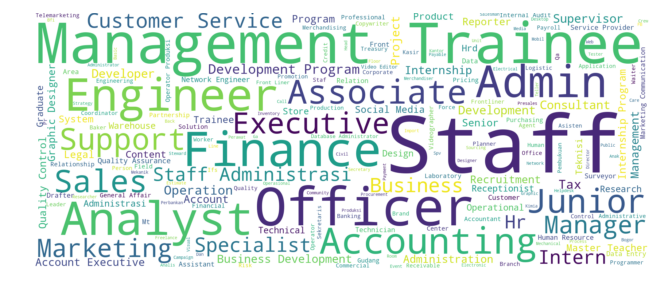

In [6]:
word = " ".join(i for i in dua["Title"])
wordcloud = WordCloud(background_color="white", width=2000, height=836).generate(word)
plt.figure(figsize=(11,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show() #Most frequent job title offered

# Location Column

In [7]:
locator = Nominatim(user_agent="myGeocoder")
lat = []
long = []
k = data["Location"].value_counts()
for i in k.index:
    try:
        latt = locator.geocode(i, timeout=10)[1][0]
        lat.append(latt)
        longg = locator.geocode(i, timeout=10)[1][1]
        long.append(longg)
    except GeocoderTimedOut:
        latt = locator.geocode(i, timeout=10)[1][0]
        lat.append(latt)
        longg = locator.geocode(i, timeout=10)[1][1]
        long.append(longg)

In [8]:
lat, long = pd.Series(lat) , pd.Series(long)

In [9]:
loc = pd.DataFrame(k).reset_index()
loc["lat"] = lat
loc["long"] = long

In [10]:
import folium
from folium.plugins import HeatMap

hmap = folium.Map(location=[-2.483383, 117.890285], zoom_start=7 )

hm_wide = HeatMap( list(zip(loc.lat.values, loc.long.values, loc.Location.values)),
                   min_opacity=0.2,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)
# render here for interactive map https://nbviewer.jupyter.org/

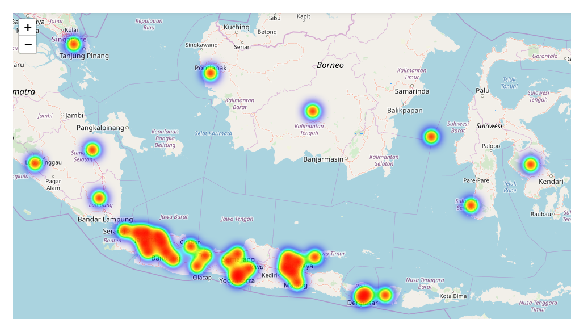

In [11]:
mapp = np.array(Image.open("mapp.png"))
plt.figure(figsize=(10, 8))
plt.imshow(mapp)
plt.xticks([])
plt.yticks([])
sns.despine(left = True, bottom = True)

# Company Column

In [12]:
company = data["Company"].str.replace(r"\s?PT[.\s]?", "", regex=True, flags=re.IGNORECASE).str.title().str.strip()
company = company.str.split("(", expand=True)[0]

In [13]:
for i in ["Ltd", "Tbk", "Inc", ","]:
    company = company.str.split(i, expand=True)[0].str.strip()

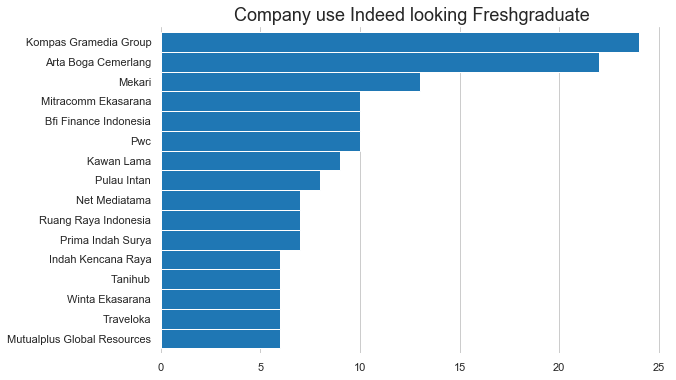

In [14]:
o = company.value_counts()
plt.figure(figsize=(9, 6))
o[o.values > 5].sort_values().plot(kind="barh", width=1)
plt.title("Company use Indeed looking Freshgraduate", size=18)
plt.grid(axis="x")
sns.despine(left = True, bottom = True)
plt.show()

# Salary Column

In [15]:
gaji = data["Salary"].str.replace(r"Rp[.]", "")
gaji = gaji.str.split(r"per", expand=True)
gaji["period"] = gaji[1]
d = gaji[0].str.split("-", expand=True)
gaji[d.columns] = d
gaji.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 3 columns):
0         128 non-null object
1         105 non-null object
period    128 non-null object
dtypes: object(3)
memory usage: 20.2+ KB


**Among 858 job posting, only 128 public the salary offer.**

In [16]:
gaji = gaji.iloc[gaji[0].dropna().index]
gaji.fillna(np.nan , inplace=True)

In [17]:
for i in gaji:
    gaji[i] = gaji[i].str.strip()
    gaji[i] = gaji[i].str.replace(".", "")

gaji[1].fillna(gaji[0], inplace=True)

In [18]:
gaji["monthly"] = gaji["period"].apply(lambda x: 4 if x == "minggu" else 30 if x =="hari" else 1)
gaji[0], gaji[1] = gaji[0].astype("int"), gaji[1].astype("int")
gaji["Salary"] = gaji.iloc[:, :2].mean(axis=1) * gaji["monthly"]
gaji["City"] = data["Location"]

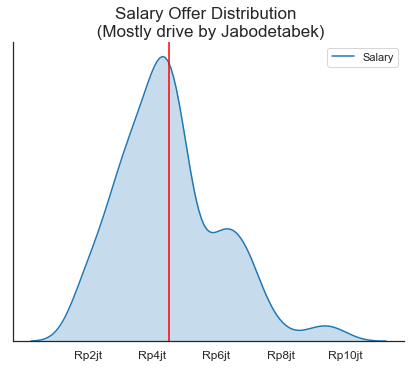

In [20]:
plt.figure(figsize=(7, 5.5))
sns.kdeplot(gaji["Salary"], shade=True)
plt.axvline(gaji["Salary"].mean(), c="red")
plt.xticks([2000000, 4000000, 6000000, 8000000, 10000000], ["Rp2jt", "Rp4jt", "Rp6jt", "Rp8jt", "Rp10jt"], size=12)
plt.title("Salary Offer Distribution \n (Mostly drive by Jabodetabek)", size=17)
plt.yticks([])
sns.despine()

In [21]:
j = gaji["City"].value_counts()
o = list(j[j >= 4].index)

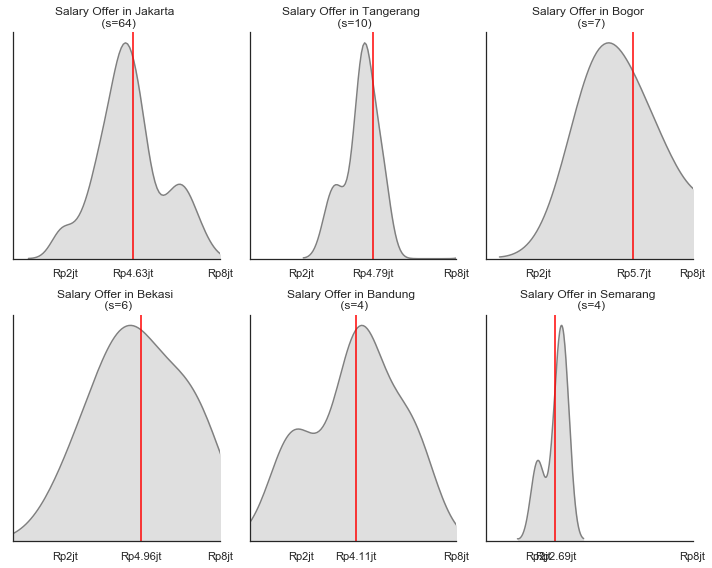

In [22]:
plt.figure(figsize=(10,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    x = gaji[gaji["City"] == o[i]]["Salary"]
    sns.kdeplot(x, shade=True, legend=False, c="grey")
    plt.axvline(x.mean(), c="red")
    sns.despine()
    plt.yticks([])
    plt.title("Salary Offer in {} \n (s={})".format(o[i], int(j[j.index == o[i]].values)))
    plt.xlim(0,8000000)
    plt.xticks([2000000,x.mean(),  8000000], ["Rp2jt", "Rp{}jt".format(round(x.mean()/1000000, 2)), "Rp8jt"])
    plt.tight_layout()

# Description Column

In [23]:
word = " ".join(review for review in data["Description"])
word = word.replace("\n", "")
print ("There are {} words in the combination of all review.".format(len(word)))

There are 807490 words in the combination of all review.


### Translate to english
---
The description column contains two different languages, english and bahasa.

In [24]:
#Method 1 (textblob)
blob = TextBlob(word)
word1 = str(blob.translate(to="en")).lower()
word1[:500]

'duties / responsibilities: doing work related to data entry positions. do data entry according to available data. make a personal data filing for accumulation per week. input every code into excel table. dominate in bogor. qualification / requirements: men and women. maximum 32 years old. in a word team research and responsible experience / fresh graduate admin support hr ga - kompas.com kompas gramediawest jakarta, indonesia full time employee data data creation statement letter creating intern'

In [ ]:
#Method 2 to translate (google translate)
lisr = [0]
en1 = []
for i in range(0,len(word), 1000):
    lisr.append(i)
    translator = Translator()
    en1.append(translator.translate(word[lisr[-2]:lisr[-1]]).text)

en = " ".join(i for i in en1)

### Set Stopword and Punctuation to exclude

In [25]:
stopwords1 = set(stopwords.words('indonesian')) # Anticipate fail translating
stopwords2 = set(stopwords.words('english'))
stopwords = stopwords1 | stopwords2 | set(string.punctuation)

## Simple Wordcloud

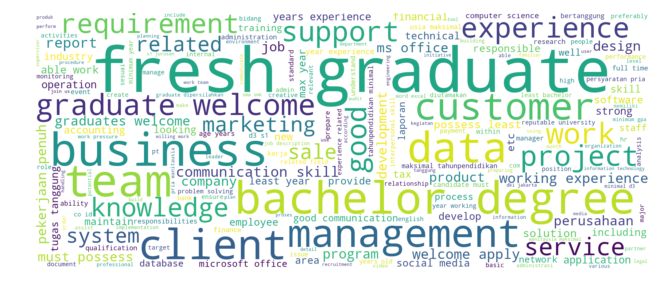

In [26]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=2000, height=836).generate(str(word1))
plt.figure(figsize=(11,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

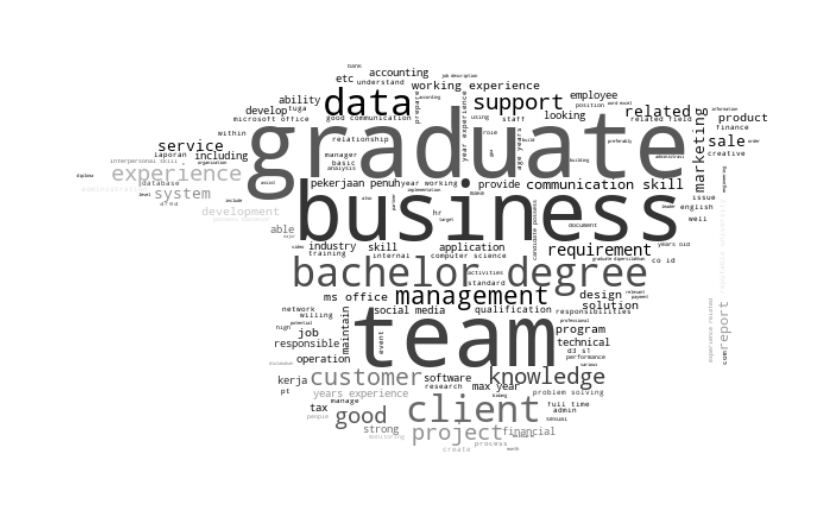

In [27]:
mask = np.array(Image.open("toga.jpg"))
image_colors = ImageColorGenerator(mask)

#eliminate the keyword
stopwords.update(["graduates", "fresh", "graduatess", "pria", "wanita", 
                  "lowongan", "lengkap", "welcome", "apply", "perusahaan", "bertanggung", "memiliki", 
                  "must", "new","work", "min", "min.", "minimal", "minimum", "maksimal", 
                  "pekerjaan:","least",  "tanggung", "company"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, mask=mask, max_words=150, background_color="white", width=2000, height=836).generate(str(word1))
plt.figure(figsize=(14,9))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Description little bit cleaned

In [28]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if (word in counts) & (word not in stopwords):
            counts[word] += 1
        elif (word not in stopwords):
            counts[word] = 1

    return counts

x = word_count(word1)
sorted_x = sorted(x.items(), key=lambda kv: kv[1], reverse=True)

In [29]:
k = []
for i in sorted_x:
    if i[1] >= 100:
        k.append(i)

In [30]:
desc = pd.DataFrame(k)
desc.columns = ["Keyword", "Values"]
rek = {"pengalaman":"experience", "s1":"bachelor", "years":"year"}
desc = desc.replace({"Keyword":rek}).groupby("Keyword", as_index=False).sum().sort_values("Values", ascending=False)

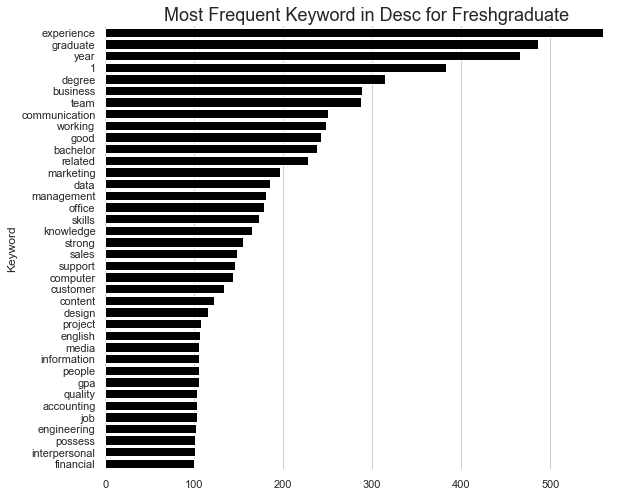

In [31]:
x_val = desc["Keyword"]
y_val = desc["Values"]

plt.figure(figsize=(9, 7))
sns.barplot(y_val, x_val, color="black")
plt.xlabel("")
plt.title("Most Frequent Keyword in Desc for Freshgraduate", size=18)
plt.grid(axis="x")
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.show()

In [32]:
#desc.to_csv("desc.csv")

In [33]:
#with open('desc.txt','w', encoding="utf-8") as out:
#    out.write(word1)

**We will explored the keyword in another notebook, focus on how the keyword relate with another word or the sentences**